# Visualization of country emissions using chorople maps and bubble charts

In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

## Load full country dataset

In [3]:
country_df = pd.read_parquet('../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v2_imputed.parquet')
country_df = country_df[country_df['Area Code'] <= 1000] #select countries only
country_df.sample(5)

,Area,Year,Area Code,Total_Energy_Emissions_(CO2)_kt,Total_Energy_Energy_use_in_agriculture_TJ,Cropland_organic_soils_Area_ha,Cropland_organic_soils_Emissions_(CO2)_kt,Cropland_organic_soils_Net_stock_change_(C)_kt,Drained_organic_soils_Area_ha,Drained_organic_soils_Emissions_(CO2)_kt,...,Country_area_Area_1000_ha,Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No,Gross_Domestic_Product_Annual_growth_US$_per_capita_%,Gross_Domestic_Product_Value_US$_million_USD,Gross_Domestic_Product_Value_US$_per_capita_USD,Total_Energy_Emissions_(CH4_CO2eq)_kt,Total_Energy_Emissions_(N2O_CO2eq)_kt,Cropland_organic_soils_Emissions_(N2O_CO2eq)_kt,Drained_organic_soils_Emissions_(N2O_CO2eq)_kt,Grassland_organic_soils_Emissions_(N2O_CO2eq)_kt
3217,Guadeloupe,2005,87.0,100.1415,1551.5207,0.0000,0.0000,0.0000,0.0000,0.0000,...,170.0,403.233,NaN,NaN,NaN,0.4676,5.3000,0.0000,0.0000,0.0000
4933,Malawi,1999,130.0,31.9704,391.6225,16213.3959,832.2877,226.9875,16990.3484,859.6364,...,11848.0,10973.956,-2.367055,3208.978291,292.417638,0.0784,2.1730,33.7610,35.3775,1.6165
5591,Namibia,1985,147.0,221.1558,2964.3857,0.0000,0.0000,0.0000,67.3398,2.3704,...,82429.0,1093.311,-19.921326,1605.929721,1468.868163,0.4368,18.0200,0.0000,0.1325,0.1325
3900,Ireland,2016,104.0,876.8684,10777.0227,27719.3330,764.9844,208.6321,880143.3933,11352.2990,...,7028.0,4715.788,1.391854,298888.093666,63380.307526,1.3972,57.3195,142.9675,2647.2970,1884.7065
2304,Equatorial Guinea,2016,61.0,136.3206,1968.0433,16.2385,0.0000,0.0000,16.6659,0.0000,...,2805.0,1398.927,-17.852596,11240.814853,8035.311959,0.6132,4.2135,0.0000,0.0000,0.0000


## Load corrected country names compatible with geopandas

In [4]:
country_codes = pd.read_csv('../data/FAOSTAT/clean_data/fao_country_codes_corrected.csv')
country_codes.sample(5)

,Area Code,Area
0,1,Armenia
252,5815,Low Income Food Deficit Countries
52,62,Ethiopia
27,34,Canton and Enderbury Islands
87,106,Italy


## Load world geometries.

### I need "iso_a3" codes to plot on map

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.sample(5)

C:\Users\UX433F\AppData\Local\Temp\ipykernel_20136\758265142.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
136,4917000.0,Oceania,New Zealand,NZL,206928,"MULTIPOLYGON (((176.88582 -40.06598, 176.50802..."
25,58558270.0,Africa,South Africa,ZAF,351431,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082..."
58,8082366.0,Africa,Togo,TGO,5490,"POLYGON ((0.89956 10.99734, 0.77234 10.47081, ..."
114,8877067.0,Europe,Austria,AUT,445075,"POLYGON ((16.97967 48.12350, 16.90375 47.71487..."
39,390353.0,North America,Belize,BLZ,1879,"POLYGON ((-89.14308 17.80832, -89.15091 17.955..."


## Merge country dataset with geopandas nomenclature

In [6]:
pd.set_option('display.max_rows', 100)
country_df = pd.merge(country_df.drop('Area', axis=1), country_codes, how='left', on='Area Code')
country_df[['Area Code', 'Area']].drop_duplicates().query('Area.isnull()').tail()

,Area Code,Area
10290,280.0,NaN
10332,281.0,NaN
10374,282.0,NaN
10416,283.0,NaN
10500,351.0,NaN


In [7]:
#Impute manually only "china". Has several regions and names.
#rest of missing country names are small islands, etc. I drop them for now.

country_df['Area'] = np.where(country_df['Area Code'] == 351, 'China', country_df['Area'])
country_df = country_df.dropna(subset=['Area'])

## Choropleth year 2021

In [8]:
# Define dummy target emissions column. After cleaning dataset, you can replace this with actual emissions data
target = 'Emissions_from_livestock_Emissions_(CO2eq)_(AR5)_kt'
year = 2021

In [9]:
df_2021 = country_df[country_df['Year'] == year][['Area', target]].dropna()
df_2021 = df_2021.groupby('Area').sum().reset_index()

In [10]:
# Merge the data with the world GeoDataFrame
world = world.merge(df_2021, how='left', left_on='name', right_on='Area').dropna()

### Map by country - total value

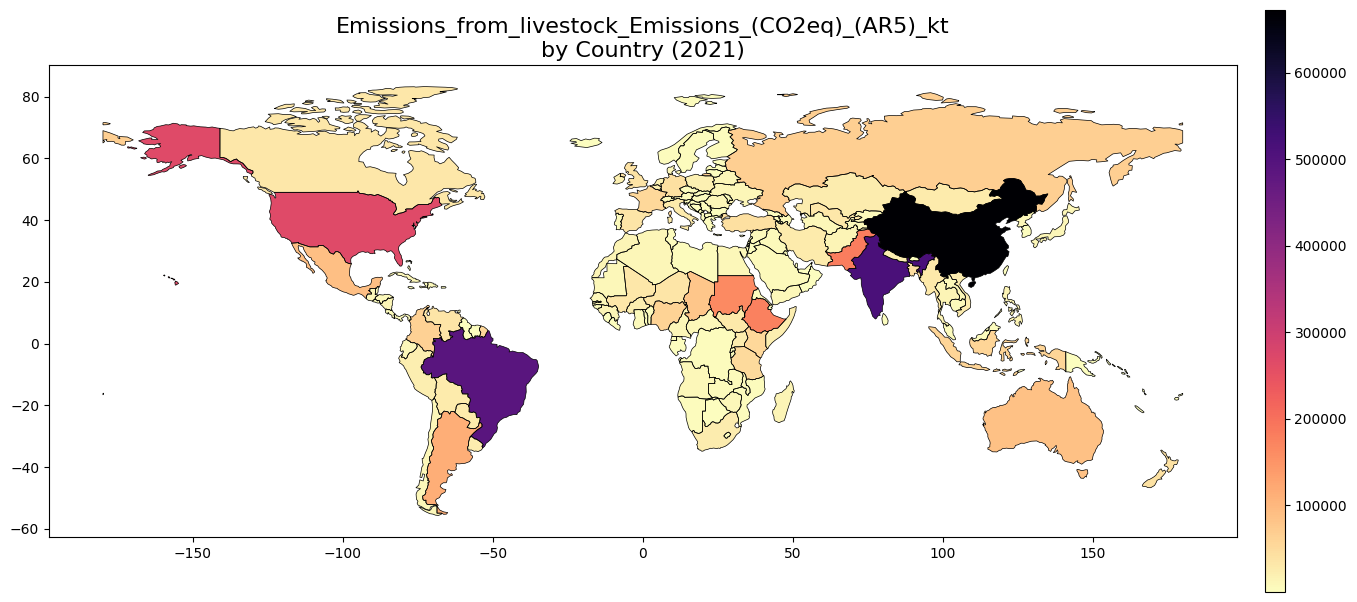

In [15]:
# Get the reversed magma color palette from Seaborn, same as for treemap plots
magma_palette_reversed = sns.color_palette("magma_r", as_cmap=True)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot with custom legend parameters
plot = world.plot(column=target, ax=ax, legend=True,
                  legend_kwds={'orientation': "vertical",
                               'shrink': 0.6,  # Make colorbar smaller
                               'aspect': 30,   # Make colorbar thinner
                               'pad': 0.02},   # Adjust padding
                  cmap=magma_palette_reversed)

plt.title(f"{target}\nby Country ({year})", fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

### Map by country - per capita emissions

In [16]:
world[target] = world[target] / world['pop_est']  # per capita emissions

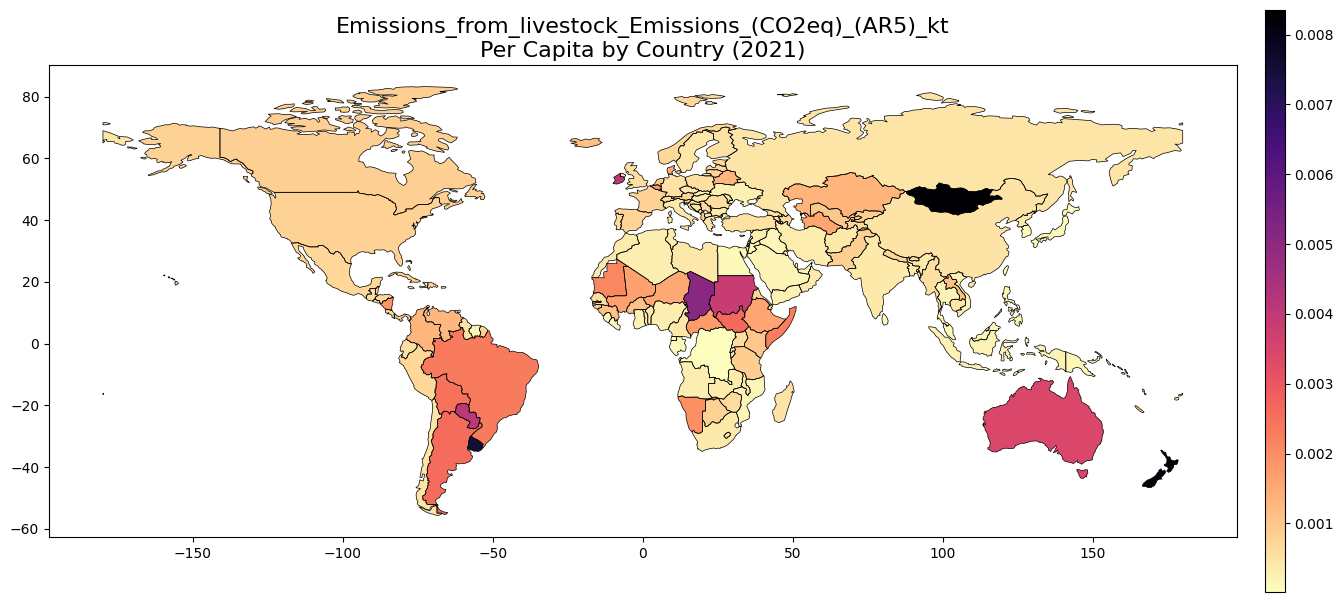

In [17]:
# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot with custom legend parameters
plot = world.plot(column=target, ax=ax, legend=True,
                  legend_kwds={'orientation': "vertical",
                               'shrink': 0.6,  # Make colorbar smaller
                               'aspect': 30,   # Make colorbar thinner
                               'pad': 0.02},   # Adjust padding
                  cmap=magma_palette_reversed)

plt.title(f"{target}\nPer Capita by Country ({year})", fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Interactive map with plotly express

In [352]:
df = country_df[['Year', 'Area', target]].dropna()
df = df.groupby(['Year', 'Area']).sum().reset_index()

# Merge the data with the world GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_full = world.merge(df, how='left', left_on='name', right_on='Area').dropna()

C:\Users\UX433F\AppData\Local\Temp\ipykernel_21340\4220431971.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



### Total emissions by country over time

In [353]:
# Get the reversed magma color palette from Seaborn
magma_palette_reversed = sns.color_palette("magma_r", n_colors=256)

# Convert the Seaborn color palette to a format Plotly can use
magma_plotly = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in magma_palette_reversed]

# Calculate global min and max
vmin = world_full[target].min()
vmax = world_full[target].max()

# Plot the interactive choropleth map
fig = px.choropleth(
    world_full, 
    locations='iso_a3', 
    locationmode='ISO-3', 
    color=target, 
    hover_name='iso_a3', 
    animation_frame='Year',
    color_continuous_scale=magma_plotly,  # Use the custom color scale
    range_color=(vmin, vmax)  # Set the range of the color scale
)

fig.update_layout(
    width=1000,
    height=600,
    title={
        'text': f'{target}<br>by Country Over the Years',
        'x': 0.5,
        'xanchor': 'center'
    },
    coloraxis_colorbar=dict(
        title=""
    )
)

fig.write_html(f"../plots/{target}_TOTAL_map.html")
fig.show()

### Per capita emissions by country over time

In [354]:
world_full[target] = world_full[target] / world_full['pop_est']  # per capita emissions

In [355]:
# Get the reversed magma color palette from Seaborn
magma_palette_reversed = sns.color_palette("magma_r", n_colors=256)

# Convert the Seaborn color palette to a format Plotly can use
magma_plotly = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in magma_palette_reversed]

# Calculate global min and max
vmin = world_full[target].min()
vmax = world_full[target].max()

# Plot the interactive choropleth map
fig = px.choropleth(
    world_full, 
    locations='iso_a3', 
    locationmode='ISO-3', 
    color=target, 
    hover_name='iso_a3', 
    animation_frame='Year',
    color_continuous_scale=magma_plotly,  # Use the custom color scale
    range_color=(vmin, vmax)  # Set the range of the color scale
)

fig.update_layout(
    width=1000,
    height=600,
    title={
        'text': f'{target}<br>Per Capita by Country Over the Years',
        'x': 0.5,
        'xanchor': 'center'
    },
    coloraxis_colorbar=dict(
        title=""
    )
)

fig.write_html(f"../plots/{target}_percapita_map.html")
fig.show()

## Save to chart studio

In [356]:
import chart_studio 

username = "ezemriv"
password = "dmanBuRgSIAPjUFi4m1X"

chart_studio.tools.set_credentials_file(username=username, api_key=password)

import chart_studio.plotly as py
import chart_studio.tools as tls

In [357]:
py.plot(fig, filename = f'{target}_per_capita', auto_open=False)

'https://plotly.com/~ezemriv/11/'

# Map colored by clusters

Same but target should be "Clusters" column